In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyxona import File
import quantities as pq
import ripple_detection as rd
import tools
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import convolve as conv
from scipy import stats
import seaborn as sns
from klepto.archives import file_archive

from params import params_ripples, params_spindles, params_maxmin_reaches

from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "/home/jovyan/work/RippleSpindleCoupling/data/"
path_res = "/home/jovyan/work/RippleSpindleCoupling/results/02/"
detect=True
detect_max_min_reaches = False


In [3]:


# load file info from names
df_info = tools.generate_fileinfo(path)

# load info from experimental nodes
fname_notes = 'NotesData.ods'
df_notes = tools.load_notes(path, fname_notes)

# merge both
df_info = pd.merge(df_notes, df_info, on=['id', 'date', 'session'])
df_info = df_info.drop(['rec_start', 'rec_stop', 'notes'], axis=1)


In [70]:
df_info

,id,date,treatment,session,hpc_rec_min,hpc_rec_max,ctx_rec_min,ctx_rec_max,fname
0,KKL196,201015,CNO,1,-750,750,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
1,KKL196,201015,CNO,2,-750,750,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
2,KKL196,201016,saline,3,-750,750,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
3,KKL196,201017,CNO,2,-750,750,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
4,KKL196,201017,CNO,3,-750,750,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
5,KKL196,201018,saline,2,-1000,1000,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
6,KKL196,201019,CNO,2,-1000,1000,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
7,KKL196,201020,saline,1,-1000,1000,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
8,KKL196,201020,saline,2,-1000,1000,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...
9,KKL196,201022,CNO,1,-1000,1000,-375,375,/home/jovyan/work/RippleSpindleCoupling/data/K...


### Detect faulty data
Before we start to quantify ripple and spindle events, we detect faulty data segments.

In [4]:
if detect_max_min_reaches:
    df_maxmin_reaches = tools.detect_maxmin_reaches_mp(
            df_info, params_maxmin_reaches, verbose=False)
    df_maxmin_reaches.to_pickle(path_res+'df_maxmin_reaches.pckl')
else:
    df_maxmin_reaches = pd.read_pickle(path_res+'df_maxmin_reaches.pckl')
    

>For ripple detection (Boyce et al., 2016; Nakashiba et al., 2009), the LFP obtained from CA1
pyramidal cell layer was first band-pass filtered (100–250 Hz), and amplitude was calculated using
the Hilbert transform. Ripple windows were characterized as signals that exceed the amplitude
threshold (three times the standard deviation). Signals that were less than 50 ms apart were merged.

> For spindle detection (Eschenko et al., 2006; Phillips et al., 2012), the LFP obtained from ACC
was band-pass filtered (12–15 Hz), and amplitude was calculated using the Hilbert transform. Spindle
windows were characterized as signals that exceed the amplitude threshold (two times the standard
deviation), with minimum and maximum duration of 200 and 2000 ms, respectively. Signals that are
less than 100 ms apart were merged.

### Detect ripples and spindles

In [89]:
arch_rppls = file_archive(path_res+'df_rppls.pckl')
arch_rppls['df'] = df_rppls

In [ ]:
arch_rppls.dump()

In [5]:
if detect:
    df_rppls, df_spndls = tools.event_detection_mp(
        df_info, params_ripples,
        params_spindles, verbose=False,
        concat_results=True)
    df_rppls.to_pickle(path_res+'df_rppls.pckl')
    df_spndls.to_pickle(path_res+'df_spndls.pckl')
else:
    df_rppls = pd.read_pickle(path_res+'df_rppls.pckl')
    df_spndls = pd.read_pickle(path_res+'df_spndls.pckl')

/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a f

/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL190, date 200917, session 1


Finished event detection for animal KKL196, date 201017, session 2


Finished event detection for animal KKL197, date 201105, session 1

Finished event detection for animal KKL190, date 200916, session 1



Finished event detection for animal KKL197, date 201107, session 1Finished event detection for animal KKL197, date 201110, session 2Finished event detection for animal KKL196, date 201020, session 1
Finished event detection for animal KKL196, date 201022, session 1










Finished event detection for animal KKL197, date 201106, session 1


Finished event detection for animal KKL196, date 201016, session 3


Finished event detection for animal KKL190, date 200915, session 2


Finished event detection for animal KKL190, date 200917, session 2


Finished event detection for animal KKL196, date 201017, session 3


Finished event detection for animal KKL197, date 201107, session 2Finished event detection for animal K

/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a f

Finished event detection for animal KKL190, date 200921, session 2




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL190, date 200922, session 1




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL190, date 200923, session 1




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL190, date 200923, session 2




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)



Finished event detection for animal KKL191, date 200914, session 1



/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)



Finished event detection for animal KKL191, date 200914, session 2



/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200915, session 1




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200916, session 2


Finished event detection for animal KKL191, date 200915, session 2




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL190, date 200921, session 1


Finished event detection for animal KKL191, date 200916, session 1




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200917, session 1


Finished event detection for animal KKL190, date 200922, session 2




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200917, session 2




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200918, session 1




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200918, session 2




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200921, session 1


Finished event detection for animal KKL191, date 200921, session 2




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200922, session 1




/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


Finished event detection for animal KKL191, date 200922, session 2


Finished event detection for animal KKL191, date 200923, session 1


Finished event detection for animal KKL191, date 200923, session 2




MemoryError: 

In [84]:
df_rppls.to_hdf(path_res+'df_rppls.pckl', 'df_rppls')

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['id', 'date', 'treatment', 'session', 'fname', 'evts_ts_strtstop',
       'evts_ampl', 'evts_ampl_ts', 'evts_data', 'evts_data_ts', 'valid'],
      dtype='object')]

  pytables.to_hdf(


MemoryError: 

In [80]:
path_res

'/home/jovyan/work/RippleSpindleCoupling/results/02/'

In [ ]:
df_rppls.info()

## Exclude ripples and spindles which are too close to a noise event

In [46]:
df_rppls['valid'] = None
noise_dt = 1.

for _, row in tqdm(df_maxmin_reaches.iterrows()):
    t_noise = row['hpc_maxmin_reaches']
    if np.any(t_noise):
        intv_noise = pd.arrays.IntervalArray.from_arrays(t_noise[:, 0]-noise_dt, t_noise[:, 1]+noise_dt)
        
        df_sel = df_rppls[
            ((df_rppls['id'] == row['id']) &
             (df_rppls['date'] == row['date']) &
             (df_rppls['session'] == row['session']))]
        for index, row_evnt in df_sel.iterrows():
            intv_evnt = pd.Interval(row_evnt['evts_ts_strtstop'][0], row_evnt['evts_ts_strtstop'][1])
            bool_overlap = intv_noise.overlaps(intv_evnt)
            if np.any(bool_overlap):
                df_rppls.loc[index, 'valid'] = False
            else:
                df_rppls.loc[index, 'valid'] = True

53it [01:32,  1.74s/it]


In [55]:
df_spndls['valid'] = None
noise_dt = 1.

for _, row in tqdm(df_maxmin_reaches.iterrows()):
    t_noise = row['ctx_maxmin_reaches']
    if np.any(t_noise):
        intv_noise = pd.arrays.IntervalArray.from_arrays(t_noise[:, 0]-noise_dt, t_noise[:, 1]+noise_dt)
        
        df_sel = df_spndls[
            ((df_spndls['id'] == row['id']) &
             (df_spndls['date'] == row['date']) &
             (df_spndls['session'] == row['session']))]
        for index, row_evnt in df_sel.iterrows():
            intv_evnt = pd.Interval(row_evnt['evts_ts_strtstop'][0], row_evnt['evts_ts_strtstop'][1])
            bool_overlap = intv_noise.overlaps(intv_evnt)
            if np.any(bool_overlap):
                df_spndls.loc[index, 'valid'] = False
            else:
                df_spndls.loc[index, 'valid'] = True

53it [00:05,  9.34it/s]


In [50]:
np.sum(df_rppls['valid']==False)

34380

In [49]:
np.sum(df_rppls['valid'])

20313

In [68]:
np.sum(df_spndls['valid']==False)

2560

In [69]:
np.sum(df_spndls['valid']==True)

3232

### Event rate by animal, date and session

In [58]:
# check that only one duration exists per session
assert np.all([len(i)==1 for i in df_rppls.groupby(['id', 'date', 'session'])['duration'].unique()])
t_trial = df_rppls.groupby(['id', 'date', 'session'])['duration'].mean()

In [39]:
n_rppls_trial = df_rppls[df_rppls['valid']==True].groupby(['id', 'date', 'session']).size()
n_spndls_trial = df_spndls.groupby(['id', 'date', 'session']).size()

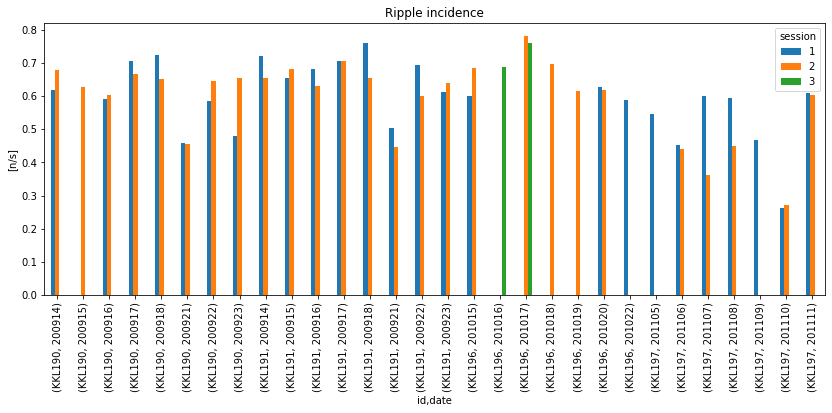

In [40]:
rppl_incidence = n_rppls_trial/t_trial
fig, ax = plt.subplots(1, figsize=(14, 5))
rppl_incidence.unstack().plot.bar(ax=ax, rot=90)
ax.set_title('Ripple incidence')
ax.set_ylabel('[n/s]')
plt.savefig('RippleIncidence.png')

In [41]:
spndl_incidence = n_spndls_trial/t_trial

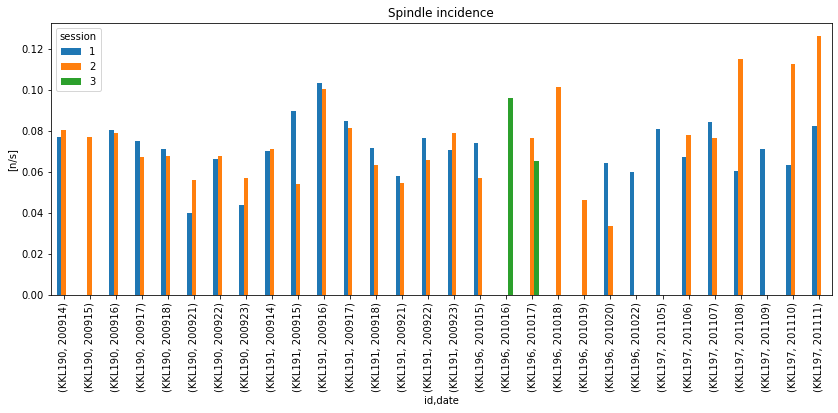

In [42]:
fig, ax = plt.subplots(1, figsize=(14, 5))
spndl_incidence.unstack().plot.bar(ax=ax, rot=90)
ax.set_title('Spindle incidence')
ax.set_ylabel('[n/s]')
plt.savefig('SpindleIncidence.png')

In [60]:
n_rppls_trial = df_rppls[df_rppls['valid']==True].groupby(['id', 'date', 'session']).size()
n_spndls_trial = df_spndls[df_spndls['valid']==True].groupby(['id', 'date', 'session']).size()

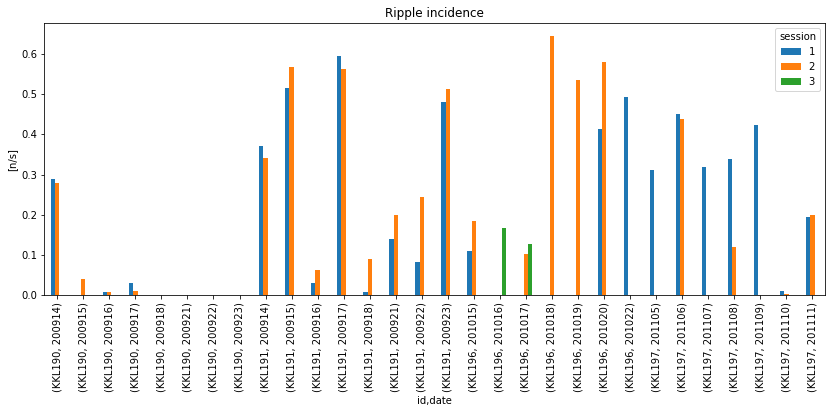

In [61]:
rppl_incidence = n_rppls_trial/t_trial
fig, ax = plt.subplots(1, figsize=(14, 5))
rppl_incidence.unstack().plot.bar(ax=ax, rot=90)
ax.set_title('Ripple incidence')
ax.set_ylabel('[n/s]')
plt.savefig('RippleIncidence.png')

In [62]:
spndl_incidence = n_spndls_trial/t_trial

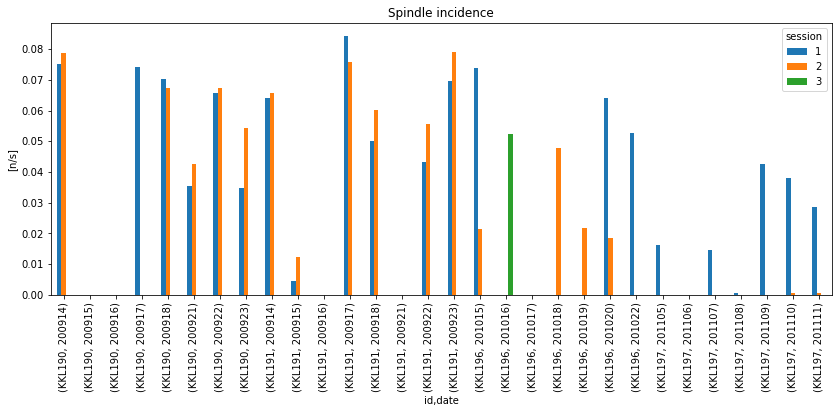

In [63]:
fig, ax = plt.subplots(1, figsize=(14, 5))
spndl_incidence.unstack().plot.bar(ax=ax, rot=90)
ax.set_title('Spindle incidence')
ax.set_ylabel('[n/s]')
plt.savefig('SpindleIncidence.png')

### Event rate by animal, and treatment


In [43]:
assert np.all([len(i)==1 for i in df_rppls.groupby(['id', 'date', 'session', 'treatment'])['duration'].unique()])
t_trial = df_rppls.groupby(['id', 'date', 'session', 'treatment'])['duration'].mean()
assert np.all(t_trial == df_spndls.groupby(['id', 'date', 'session', 'treatment'])['duration'].mean())

n_rppls_trial = df_rppls.groupby(['id', 'date', 'session', 'treatment']).size()
n_spndls_trial = df_spndls.groupby(['id', 'date', 'session', 'treatment']).size()

rppl_incidence = n_rppls_trial/t_trial
spndl_incidence = n_spndls_trial/t_trial

rppl_incidence = rppl_incidence.to_frame('incidence').reset_index()
spndl_incidence = spndl_incidence.to_frame('incidence').reset_index()

In [44]:
ls_p_val = []
for df_i in [rppl_incidence, spndl_incidence]:
    p_val = {}
    gb_i = df_i.groupby(['id', 'treatment'])

    for (n0, v0), (n1, v1) in zip(np.array(gb_i)[::2], np.array(gb_i)[1::2]):
        assert n0[0] == n1[0]

        p_val_i = stats.mannwhitneyu(v0.incidence, v1.incidence)[1]
        p_val[n0[0]] = p_val_i
    ls_p_val.append(p_val)

<ipython-input-44-4b350ca248b4>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for (n0, v0), (n1, v1) in zip(np.array(gb_i)[::2], np.array(gb_i)[1::2]):


p value, Mann-Whitney-U test:
{'KKL190': 0.30126217618064843, 'KKL191': 0.21544852186813368, 'KKL196': 0.37455956650029765, 'KKL197': 0.032776080582751284}


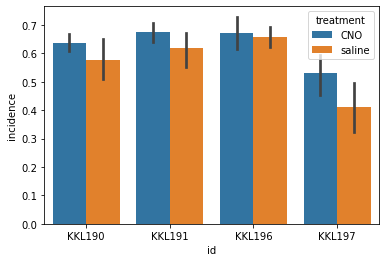

In [45]:
sns.barplot(x="id", y='incidence', hue='treatment', data=rppl_incidence)
print('p value, Mann-Whitney-U test:')
print(ls_p_val[0])

p value, Mann-Whitney-U test:
{'KKL190': 0.018451976806859085, 'KKL191': 0.31825124345693306, 'KKL196': 0.29701617029952077, 'KKL197': 0.18923879662233944}


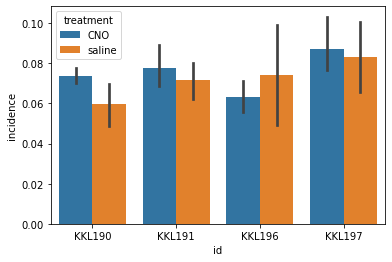

In [46]:
sns.barplot(x="id", y='incidence', hue='treatment', data=spndl_incidence)
print('p value, Mann-Whitney-U test:')
print(ls_p_val[1])

### Event rate by animal, and treatment


In [64]:
assert np.all([len(i)==1 for i in df_rppls.groupby(['id', 'date', 'session', 'treatment'])['duration'].unique()])
t_trial = df_rppls.groupby(['id', 'date', 'session', 'treatment'])['duration'].mean()
assert np.all(t_trial == df_spndls.groupby(['id', 'date', 'session', 'treatment'])['duration'].mean())

n_rppls_trial = df_rppls[df_rppls['valid']==True].groupby(['id', 'date', 'session', 'treatment']).size()
n_spndls_trial = df_spndls[df_spndls['valid']==True].groupby(['id', 'date', 'session', 'treatment']).size()

rppl_incidence = n_rppls_trial/t_trial
spndl_incidence = n_spndls_trial/t_trial

rppl_incidence = rppl_incidence.to_frame('incidence').reset_index()
spndl_incidence = spndl_incidence.to_frame('incidence').reset_index()

In [65]:
ls_p_val = []
for df_i in [rppl_incidence, spndl_incidence]:
    p_val = {}
    gb_i = df_i.groupby(['id', 'treatment'])

    for (n0, v0), (n1, v1) in zip(np.array(gb_i)[::2], np.array(gb_i)[1::2]):
        assert n0[0] == n1[0]

        p_val_i = stats.mannwhitneyu(v0.incidence, v1.incidence)[1]
        p_val[n0[0]] = p_val_i
    ls_p_val.append(p_val)

<ipython-input-65-4b350ca248b4>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for (n0, v0), (n1, v1) in zip(np.array(gb_i)[::2], np.array(gb_i)[1::2]):


p value, Mann-Whitney-U test:
{'KKL190': 0.07382429440323693, 'KKL191': 0.003702766670250134, 'KKL196': 0.08290328009700676, 'KKL197': 0.28758676596009836}


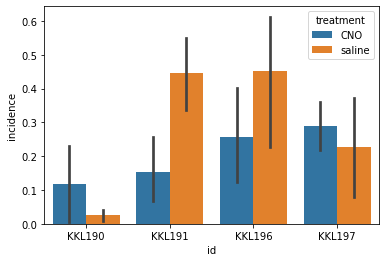

In [66]:
sns.barplot(x="id", y='incidence', hue='treatment', data=rppl_incidence)
print('p value, Mann-Whitney-U test:')
print(ls_p_val[0])

p value, Mann-Whitney-U test:
{'KKL190': 0.19270911618411474, 'KKL191': 0.21544852186813368, 'KKL196': 0.16867782588818075, 'KKL197': 0.23402080295020827}


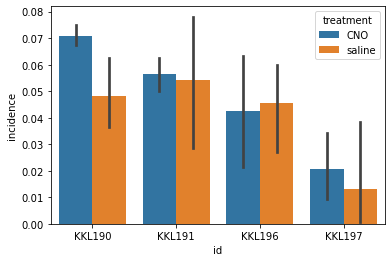

In [67]:
sns.barplot(x="id", y='incidence', hue='treatment', data=spndl_incidence)
print('p value, Mann-Whitney-U test:')
print(ls_p_val[1])

### Visualize events

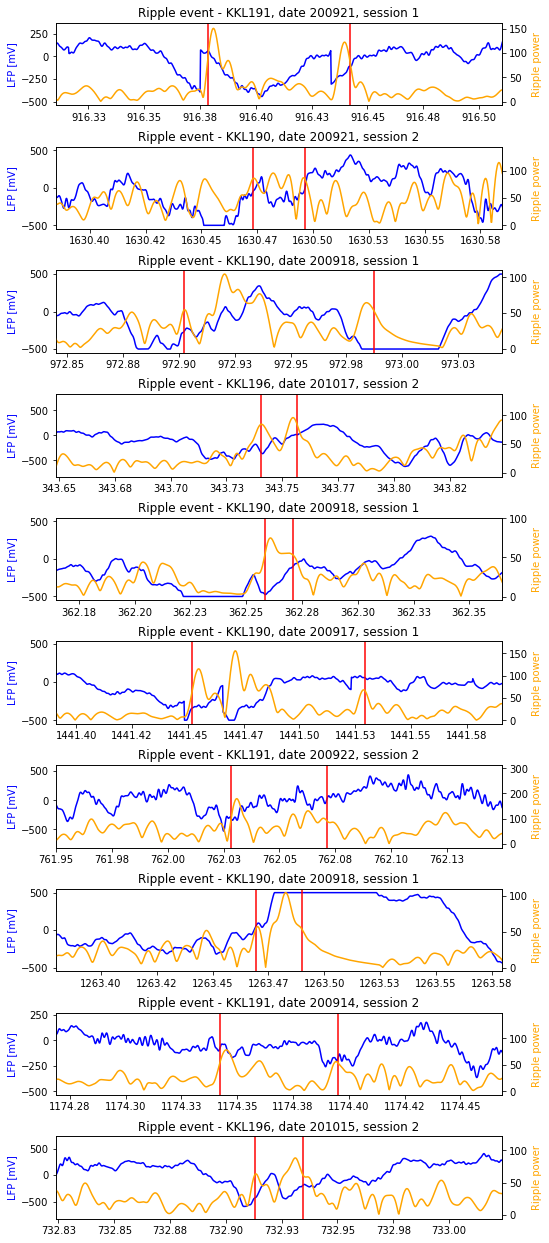

In [47]:
n = 10

ids = np.random.choice(np.arange(len(df_rppls)), n, replace=False)

fig, ax = plt.subplots(n, figsize=(8, 22), gridspec_kw={'hspace': 0.5})

for i in range(n):
    df_i = df_rppls.loc[ids[i]]
    ax[i].plot(df_i.evts_data_ts, df_i.evts_data, c='b')    
    ax[i].axvline(df_i.evts_ts_strtstop[0], c='r')
    ax[i].axvline(df_i.evts_ts_strtstop[1], c='r')
    ax[i].set_xlim((df_i.evts_ts_center-0.1, df_i.evts_ts_center+0.1))
    ax[i].set_ylabel('LFP [mV]', color='b')
    ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #ax[i].tick_params(axis='x', labelrotation=30)
    ax_ampl = ax[i].twinx()
    ax_ampl.plot(df_i.evts_ampl_ts, df_i.evts_ampl, color='orange')
    ax_ampl.set_ylabel('Ripple power', color='orange')
    ax[i].set_title("Ripple event - " +df_i['id'] + ', date ' + df_i['date'] + ', session ' + df_i['session'])
            

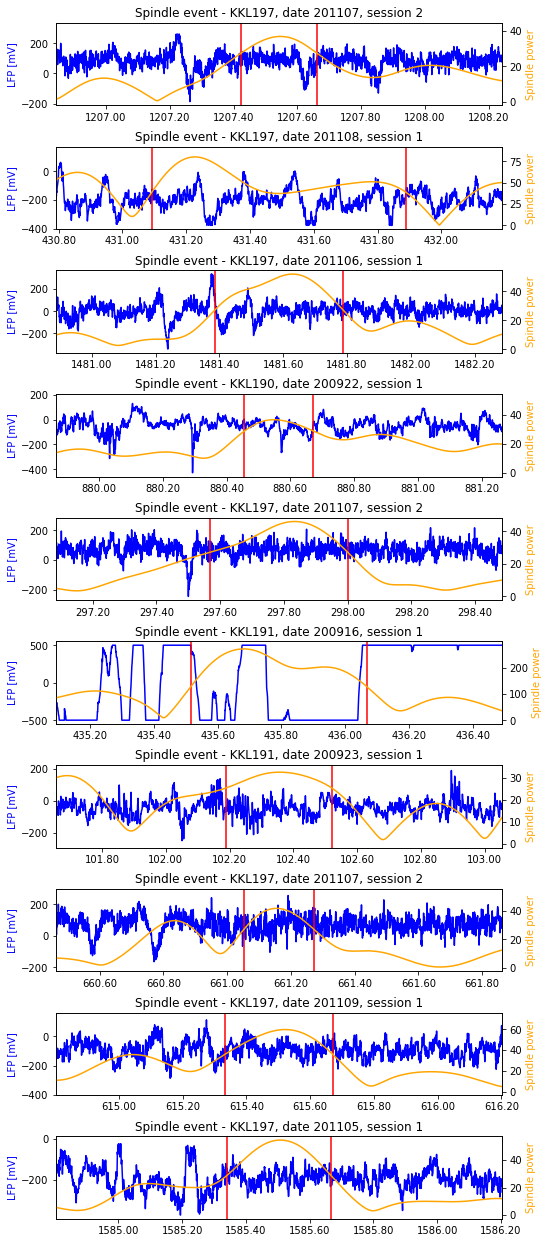

In [48]:
n = 10

ids = np.random.choice(np.arange(len(df_spndls)), n, replace=False)

fig, ax = plt.subplots(n, figsize=(8, 22), gridspec_kw={'hspace': 0.5})

for i in range(n):
    df_i = df_spndls.loc[ids[i]]
    ax[i].plot(df_i.evts_data_ts, df_i.evts_data, c='b')    
    ax[i].axvline(df_i.evts_ts_strtstop[0], c='r')
    ax[i].axvline(df_i.evts_ts_strtstop[1], c='r')
    ax[i].set_xlim((df_i.evts_ts_center-.7, df_i.evts_ts_center+.7))
    ax[i].set_ylabel('LFP [mV]', color='b')
    ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #ax[i].tick_params(axis='x', labelrotation=30)
    ax_ampl = ax[i].twinx()
    ax_ampl.plot(df_i.evts_ampl_ts, df_i.evts_ampl, color='orange')
    ax_ampl.set_ylabel('Spindle power', color='orange')
    ax[i].set_title("Spindle event - " +df_i['id'] + ', date ' + df_i['date'] + ', session ' + df_i['session'])
            

## Crosscorrelation analysis
For each session, check for proportion of ripple/spindle pairs that co-occur within 4 seconds, measured from center to center.
For each pair, calculate amplitude correlation.

> Adhikari 2010: .5.3. Cross-correlation of the instantaneous amplitudes
After the instantaneous amplitude for all the points in the vHPC
and mPFC signals was calculated, the cross-correlation between
the amplitudes of the two signals was computed with the MAT-
LAB function xcorr, over lags ranging from +0.1 to −0.1 s. The
mean amplitude was first subtracted from each vector prior to
cross-correlating them, as the DC component of a signal has no rele-
vance for a cross-correlation. The lag at which the cross-correlation
peaked was then determined. The significance of each vHPC–mPFC
theta amplitude cross-correlation was verified before inclusion in
additional analyses using a bootstrap procedure. mPFC and vHPC
theta-amplitude envelopes were randomly shifted 5–10 s relative
to each other 1000 times. The shifted amplitude envelopes were
then cross-correlated, yielding a distribution of cross-correlation
peaks expected by chance. The original cross-correlation was con-
sidered significant if its peak value was greater than 95% of these
randomly generated cross-correlation peaks. The peaks of the
mPFC–vHPC theta-filtered amplitude envelope cross-correlations
of all 17 animals were significant by this criterion.

In [ ]:
params_xcorr = {
    'delta_t': 4,  # [s], length of xcorr, scale later to 4 s
    'sampling_rate': 4800,  # [Hz] Sampling rate of the data
}
sampling_interval = 1./params_xcorr['sampling_rate']
n_bins = int(params_xcorr['delta_t']/sampling_interval)

In [ ]:
gb_spndls = dict(list(df_spndls.groupby(['id', 'date', 'session'])))
gb_rppls = dict(list(df_rppls.groupby(['id', 'date', 'session'])))

keys_spnlds = list(gb_spndls.keys())
keys_rppls = list(gb_rppls.keys())
assert keys_spnlds==keys_rppls

ls_res = []
for key_i in tqdm(keys_spnlds):
    
    # get center times of events in each group
    df_s_i = gb_spndls[key_i]
    df_r_i = gb_rppls[key_i]
    t_s = df_s_i.evts_ts_center
    t_r = df_r_i.evts_ts_center
    
    # find event pairs where difference between center times is smaller than delta_t   
    mesh = np.array(np.meshgrid(t_s, t_r))
    mesh_diff = mesh[0, :, :]-mesh[1, :, :]
    mesh_pos = np.where(np.abs(mesh_diff)<=params_xcorr['delta_t'])
    rs_pairs = list(zip(mesh_pos[0], mesh_pos[1]))
    
    # for each pair get 
    for pair_i in rs_pairs:
        row_r = df_r_i.iloc[pair_i[0]]
        row_s = df_s_i.iloc[pair_i[1]]
        
        x_s = row_s['evts_ampl']
        x_s = x_s-np.mean(x_s)

        x_r = df_r_i.iloc[12]['evts_ampl']
        x_r = x_r-np.mean(x_r)

        t_s_i = row_s.evts_ts_center
        
        # convolve
        a = conv(x_s, x_r, 'same')
        # take snippet that matches timewindow
        bin_t_s = int(len(x_s)/2.)
        a = a[bin_t_s-n_bins:bin_t_s+n_bins]
        
        res_ii = {
            'id': key_i[0],
            'date': key_i[1],
            'session': key_i[2],
            'index_s': row_s['index'],
            'index_r': row_r['index'],
            'evts_ts_center_s': row_s.evts_ts_center,
            'evts_ts_center_r': row_r.evts_ts_center,
            'xcorr': a
        }
        ls_res.append(res_ii)
df_xcorr = pd.DataFrame(ls_res)

In [ ]:
df_xcorr = pd.DataFrame(ls_res)

In [ ]:
gb_id_date = dict(list(df_xcorr.groupby(['id','date'])))

In [ ]:
keys = list(gb_id_date.keys())

In [ ]:
ls_xcorr_mean = []
for key_i in keys:
    df_i = gb_id_date[key_i]
    ar = np.vstack(df_i.xcorr)
    ls_xcorr_mean.append(np.mean(ar, axis=0))

In [ ]:
for i, key_i in enumerate(keys):
    plt.figure()
    plt.plot(ls_xcorr_mean[i])
    plt.title(key_i)

In [ ]:
gb_info = dict(list(df_info.groupby(['id', 'date'])))